This kernel is totally based on [Catboost - Some more features](https://www.kaggle.com/braquino/catboost-some-more-features) kernel.

The main purpose of this kernel is to blend catboost and lightgbm.

### next steps
    1. lgbm: use qwk as evaluation metric

In [1]:
import numpy as np
import pandas as pd
import datetime
from catboost import CatBoostClassifier
from time import time
from tqdm import tqdm_notebook as tqdm
from collections import Counter
from scipy import stats
import lightgbm as lgb

In [2]:
from sklearn.metrics import confusion_matrix
# this function is the quadratic weighted kappa (the metric used for the competition submission)
def qwk(act,pred,n=4,hist_range=(0,3)):
    
    # Calculate the percent each class was tagged each label
    O = confusion_matrix(act,pred)
    # normalize to sum 1
    O = np.divide(O,np.sum(O))
    
    # create a new matrix of zeroes that match the size of the confusion matrix
    # this matriz looks as a weight matrix that give more weight to the corrects
    W = np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            # makes a weird matrix that is bigger in the corners top-right and botton-left (= 1)
            W[i][j] = ((i-j)**2)/((n-1)**2)
            
    # make two histograms of the categories real X prediction
    act_hist = np.histogram(act,bins=n,range=hist_range)[0]
    prd_hist = np.histogram(pred,bins=n,range=hist_range)[0]
    
    # multiply the two histograms using outer product
    E = np.outer(act_hist,prd_hist)
    E = np.divide(E,np.sum(E)) # normalize to sum 1
    
    # apply the weights to the confusion matrix
    num = np.sum(np.multiply(W,O))
    # apply the weights to the histograms
    den = np.sum(np.multiply(W,E))
    
    return 1-np.divide(num,den)
    

In [3]:
nrows = 100000
nrows = None
train = pd.read_csv('../input/data-science-bowl-2019/train.csv', nrows=nrows)
train_labels = pd.read_csv('../input/data-science-bowl-2019/train_labels.csv', nrows=nrows)
specs = pd.read_csv('../input/data-science-bowl-2019/specs.csv', nrows=nrows)
test = pd.read_csv('../input/data-science-bowl-2019/test.csv', nrows=nrows)
submission = pd.read_csv('../input/data-science-bowl-2019/sample_submission.csv')

In [4]:
train.head()

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
0,27253bdc,45bb1e1b6b50c07b,2019-09-06T17:53:46.937Z,"{""event_code"": 2000, ""event_count"": 1}",0001e90f,1,2000,0,Welcome to Lost Lagoon!,Clip,NONE
1,27253bdc,17eeb7f223665f53,2019-09-06T17:54:17.519Z,"{""event_code"": 2000, ""event_count"": 1}",0001e90f,1,2000,0,Magma Peak - Level 1,Clip,MAGMAPEAK
2,77261ab5,0848ef14a8dc6892,2019-09-06T17:54:56.302Z,"{""version"":""1.0"",""event_count"":1,""game_time"":0...",0001e90f,1,2000,0,Sandcastle Builder (Activity),Activity,MAGMAPEAK
3,b2dba42b,0848ef14a8dc6892,2019-09-06T17:54:56.387Z,"{""description"":""Let's build a sandcastle! Firs...",0001e90f,2,3010,53,Sandcastle Builder (Activity),Activity,MAGMAPEAK
4,1bb5fbdb,0848ef14a8dc6892,2019-09-06T17:55:03.253Z,"{""description"":""Let's build a sandcastle! Firs...",0001e90f,3,3110,6972,Sandcastle Builder (Activity),Activity,MAGMAPEAK


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11341042 entries, 0 to 11341041
Data columns (total 11 columns):
event_id           object
game_session       object
timestamp          object
event_data         object
installation_id    object
event_count        int64
event_code         int64
game_time          int64
title              object
type               object
world              object
dtypes: int64(3), object(8)
memory usage: 951.8+ MB


In [6]:
train_labels.head()

,game_session,installation_id,title,num_correct,num_incorrect,accuracy,accuracy_group
0,6bdf9623adc94d89,0006a69f,Mushroom Sorter (Assessment),1,0,1.0,3
1,77b8ee947eb84b4e,0006a69f,Bird Measurer (Assessment),0,11,0.0,0
2,901acc108f55a5a1,0006a69f,Mushroom Sorter (Assessment),1,0,1.0,3
3,9501794defd84e4d,0006a69f,Mushroom Sorter (Assessment),1,1,0.5,2
4,a9ef3ecb3d1acc6a,0006a69f,Bird Measurer (Assessment),1,0,1.0,3


In [8]:
train_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17690 entries, 0 to 17689
Data columns (total 7 columns):
game_session       17690 non-null object
installation_id    17690 non-null object
title              17690 non-null object
num_correct        17690 non-null int64
num_incorrect      17690 non-null int64
accuracy           17690 non-null float64
accuracy_group     17690 non-null int64
dtypes: float64(1), int64(3), object(3)
memory usage: 967.5+ KB


In [9]:
specs.head()

,event_id,info,args
0,2b9272f4,The end of system-initiated feedback (Correct)...,"[{""name"":""game_time"",""type"":""int"",""info"":""mill..."
1,df4fe8b6,The end of system-initiated feedback (Incorrec...,"[{""name"":""game_time"",""type"":""int"",""info"":""mill..."
2,3babcb9b,The end of system-initiated instruction event ...,"[{""name"":""game_time"",""type"":""int"",""info"":""mill..."
3,7f0836bf,The end of system-initiated instruction event ...,"[{""name"":""game_time"",""type"":""int"",""info"":""mill..."
4,ab3136ba,The end of system-initiated instruction event ...,"[{""name"":""game_time"",""type"":""int"",""info"":""mill..."


In [10]:
specs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386 entries, 0 to 385
Data columns (total 3 columns):
event_id    386 non-null object
info        386 non-null object
args        386 non-null object
dtypes: object(3)
memory usage: 9.2+ KB


In [11]:
test.head()

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
0,27253bdc,0ea9ecc81a565215,2019-09-10T16:50:24.910Z,"{""event_code"": 2000, ""event_count"": 1}",00abaee7,1,2000,0,Welcome to Lost Lagoon!,Clip,NONE
1,27253bdc,c1ea43d8b8261d27,2019-09-10T16:50:55.503Z,"{""event_code"": 2000, ""event_count"": 1}",00abaee7,1,2000,0,Magma Peak - Level 1,Clip,MAGMAPEAK
2,27253bdc,7ed86c6b72e725e2,2019-09-10T16:51:51.805Z,"{""event_code"": 2000, ""event_count"": 1}",00abaee7,1,2000,0,Magma Peak - Level 2,Clip,MAGMAPEAK
3,27253bdc,7e516ace50e7fe67,2019-09-10T16:53:12.825Z,"{""event_code"": 2000, ""event_count"": 1}",00abaee7,1,2000,0,Crystal Caves - Level 1,Clip,CRYSTALCAVES
4,7d093bf9,a022c3f60ba547e7,2019-09-10T16:54:12.115Z,"{""version"":""1.0"",""round"":0,""event_count"":1,""ga...",00abaee7,1,2000,0,Chow Time,Game,CRYSTALCAVES


In [13]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1156414 entries, 0 to 1156413
Data columns (total 11 columns):
event_id           1156414 non-null object
game_session       1156414 non-null object
timestamp          1156414 non-null object
event_data         1156414 non-null object
installation_id    1156414 non-null object
event_count        1156414 non-null int64
event_code         1156414 non-null int64
game_time          1156414 non-null int64
title              1156414 non-null object
type               1156414 non-null object
world              1156414 non-null object
dtypes: int64(3), object(8)
memory usage: 97.1+ MB


In [14]:
submission.head()

,installation_id,accuracy_group
0,00abaee7,3
1,01242218,3
2,017c5718,3
3,01a44906,3
4,01bc6cb6,3


In [15]:
submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
installation_id    1000 non-null object
accuracy_group     1000 non-null int64
dtypes: int64(1), object(1)
memory usage: 15.8+ KB


In [16]:
# LabelEncode activities and event codes
# What about OneHotEncoding

# encode title
# make a list with all the unique 'titles' from the train and test set
list_of_user_activities = list(set(train['title'].value_counts().index).union(set(test['title'].value_counts().index)))
# make a list with all the unique 'event_code' from the train and test set
list_of_event_code = list(set(train['event_code'].value_counts().index).union(set(test['event_code'].value_counts().index)))
# create a dictionary numerating the titles
activities_map = dict(zip(list_of_user_activities, np.arange(len(list_of_user_activities))))
activities_labels = dict(zip(np.arange(len(list_of_user_activities)), list_of_user_activities))

# replace the text titles withing the number titles from the dict
train['title'] = train['title'].map(activities_map)
test['title'] = test['title'].map(activities_map)
train_labels['title'] = train_labels['title'].map(activities_map)

In [17]:
# I didnt undestud why, but this one makes a dict where the value of each element is 4100 
win_code = dict(zip(activities_map.values(), (4100*np.ones(len(activities_map))).astype('int')))
# then, it set one element, the 'Bird Measurer (Assessment)' as 4110, 10 more than the rest
win_code[activities_map['Bird Measurer (Assessment)']] = 4110

In [18]:
# convert text into datetime
train['timestamp'] = pd.to_datetime(train['timestamp'])
test['timestamp'] = pd.to_datetime(test['timestamp'])

In [19]:
train.head()

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
0,27253bdc,45bb1e1b6b50c07b,2019-09-06 17:53:46.937000+00:00,"{""event_code"": 2000, ""event_count"": 1}",0001e90f,1,2000,0,28,Clip,NONE
1,27253bdc,17eeb7f223665f53,2019-09-06 17:54:17.519000+00:00,"{""event_code"": 2000, ""event_count"": 1}",0001e90f,1,2000,0,41,Clip,MAGMAPEAK
2,77261ab5,0848ef14a8dc6892,2019-09-06 17:54:56.302000+00:00,"{""version"":""1.0"",""event_count"":1,""game_time"":0...",0001e90f,1,2000,0,23,Activity,MAGMAPEAK
3,b2dba42b,0848ef14a8dc6892,2019-09-06 17:54:56.387000+00:00,"{""description"":""Let's build a sandcastle! Firs...",0001e90f,2,3010,53,23,Activity,MAGMAPEAK
4,1bb5fbdb,0848ef14a8dc6892,2019-09-06 17:55:03.253000+00:00,"{""description"":""Let's build a sandcastle! Firs...",0001e90f,3,3110,6972,23,Activity,MAGMAPEAK


In [20]:
# this is the function that convert the raw data into processed features
def get_data(user_sample, test_set=False):
    '''
    The user_sample is a DataFrame from train or test where the only one 
    installation_id is filtered
    And the test_set parameter is related with the labels processing, that is only requered
    if test_set=False
    '''
    # Constants and parameters declaration
    last_activity = 0
    user_activities_count = {'Clip':0, 'Activity': 0, 'Assessment': 0, 'Game':0}
    
    # news features: time spent in each activity
    time_spent_each_act = {actv: 0 for actv in list_of_user_activities}
    event_code_count = {eve: 0 for eve in list_of_event_code}
    last_session_time_sec = 0
    
    accuracy_groups = {0:0, 1:0, 2:0, 3:0}
    all_assessments = []
    accumulated_accuracy_group = 0
    accumulated_accuracy=0
    accumulated_correct_attempts = 0 
    accumulated_uncorrect_attempts = 0 
    accumulated_actions = 0
    counter = 0
    time_first_activity = float(user_sample['timestamp'].values[0])
    durations = []
    
    # itarates through each session of one instalation_id
    for i, session in user_sample.groupby('game_session', sort=False):
        # i = game_session_id
        # session is a DataFrame that contain only one game_session
        
        # get some sessions information
        session_type = session['type'].iloc[0]
        session_title = session['title'].iloc[0]
        
        # get current session time in seconds
        if session_type != 'Assessment':
            time_spent = int(session['game_time'].iloc[-1] / 1000)
            time_spent_each_act[activities_labels[session_title]] += time_spent
        
        # for each assessment, and only this kind off session, the features below are processed
        # and a register are generated
        if (session_type == 'Assessment') & (test_set or len(session)>1):
            # search for event_code 4100, that represents the assessments trial
            all_attempts = session.query(f'event_code == {win_code[session_title]}')
            # then, check the numbers of wins and the number of losses
            true_attempts = all_attempts['event_data'].str.contains('true').sum()
            false_attempts = all_attempts['event_data'].str.contains('false').sum()
            # copy a dict to use as feature template, it's initialized with some itens: 
            # {'Clip':0, 'Activity': 0, 'Assessment': 0, 'Game':0}
            features = user_activities_count.copy()
            features.update(time_spent_each_act.copy())
            features.update(event_code_count.copy())
            # add title as feature, remembering that title represents the name of the game
            features['session_title'] = session['title'].iloc[0] 
            # the 4 lines below add the feature of the history of the trials of this player
            # this is based on the all time attempts so far, at the moment of this assessment
            features['accumulated_correct_attempts'] = accumulated_correct_attempts
            features['accumulated_uncorrect_attempts'] = accumulated_uncorrect_attempts
            accumulated_correct_attempts += true_attempts 
            accumulated_uncorrect_attempts += false_attempts
            # the time spent in the app so far
            if durations == []:
                features['duration_mean'] = 0
            else:
                features['duration_mean'] = np.mean(durations)
            durations.append((session.iloc[-1, 2] - session.iloc[0, 2] ).seconds)
            # the accurace is the all time wins divided by the all time attempts
            features['accumulated_accuracy'] = accumulated_accuracy/counter if counter > 0 else 0
            accuracy = true_attempts/(true_attempts+false_attempts) if (true_attempts+false_attempts) != 0 else 0
            accumulated_accuracy += accuracy
            # a feature of the current accuracy categorized
            # it is a counter of how many times this player was in each accuracy group
            if accuracy == 0:
                features['accuracy_group'] = 0
            elif accuracy == 1:
                features['accuracy_group'] = 3
            elif accuracy == 0.5:
                features['accuracy_group'] = 2
            else:
                features['accuracy_group'] = 1
            features.update(accuracy_groups)
            accuracy_groups[features['accuracy_group']] += 1
            # mean of the all accuracy groups of this player
            features['accumulated_accuracy_group'] = accumulated_accuracy_group/counter if counter > 0 else 0
            accumulated_accuracy_group += features['accuracy_group']
            # how many actions the player has done so far, it is initialized as 0 and updated some lines below
            features['accumulated_actions'] = accumulated_actions
            
            # there are some conditions to allow this features to be inserted in the datasets
            # if it's a test set, all sessions belong to the final dataset
            # it it's a train, needs to be passed throught this clausule: session.query(f'event_code == {win_code[session_title]}')
            # that means, must exist an event_code 4100 or 4110
            if test_set:
                all_assessments.append(features)
            elif true_attempts+false_attempts > 0:
                all_assessments.append(features)
                
            counter += 1
        
        # this piece counts how many actions was made in each event_code so far
        n_of_event_codes = Counter(session['event_code'])
        
        for key in n_of_event_codes.keys():
            event_code_count[key] += n_of_event_codes[key]

        # counts how many actions the player has done so far, used in the feature of the same name
        accumulated_actions += len(session)
        if last_activity != session_type:
            user_activities_count[session_type] += 1
            last_activitiy = session_type
    # if it't the test_set, only the last assessment must be predicted, the previous are scraped
    if test_set:
        return all_assessments[-1]
    # in the train_set, all assessments goes to the dataset
    return all_assessments

In [21]:
# here the get_data function is applyed to each installation_id and added to the compile_data list
compiled_data = []
# tqdm is the library that draws the status bar below
for i, (ins_id, user_sample) in tqdm(enumerate(train.groupby('installation_id', sort=False)), total=17000):
    # user_sample is a DataFrame that contains only one installation_id
    compiled_data += get_data(user_sample)

In [22]:
# the compiled_data is converted to DataFrame and deleted to save memmory
new_train = pd.DataFrame(compiled_data)
del compiled_data
new_train.shape

(17690, 102)

Below are the features I have generated. Note that all of them are **prior** to each event. For example, the first row shows **before** this assessment, the player have watched 3 clips, did 3 activities, played 4 games and solved 0 assessments, so on so forth.

In [23]:
pd.set_option('display.max_columns', None)
new_train[:10]

,Clip,Activity,Assessment,Game,Egg Dropper (Activity),Crystal Caves - Level 3,Rulers,Cart Balancer (Assessment),Treasure Map,Bottle Filler (Activity),Flower Waterer (Activity),Scrub-A-Dub,Chicken Balancer (Activity),Happy Camel,Tree Top City - Level 2,Chow Time,Tree Top City - Level 3,Chest Sorter (Assessment),Tree Top City - Level 1,Cauldron Filler (Assessment),Honey Cake,Crystal Caves - Level 1,12 Monkeys,Crystals Rule,Air Show,Dino Dive,Watering Hole (Activity),Sandcastle Builder (Activity),Ordering Spheres,Leaf Leader,Lifting Heavy Things,Bird Measurer (Assessment),Welcome to Lost Lagoon!,Balancing Act,Fireworks (Activity),Bug Measurer (Activity),Slop Problem,Magma Peak - Level 2,Costume Box,Pan Balance,Dino Drink,"Heavy, Heavier, Heaviest",All Star Sorting,Mushroom Sorter (Assessment),Bubble Bath,Magma Peak - Level 1,Crystal Caves - Level 2,Pirate's Tale,2050,4100,2060,4110,2070,2075,2080,2081,2083,3110,3120,3121,4220,4230,5000,4235,5010,4010,4020,4021,4022,4025,4030,4031,3010,4035,4040,3020,3021,4045,2000,4050,2010,2020,4070,2025,2030,4080,2035,2040,4090,4095,session_title,accumulated_correct_attempts,accumulated_uncorrect_attempts,duration_mean,accumulated_accuracy,accuracy_group,0,1,2,3,accumulated_accuracy_group,accumulated_actions
0,11,3,0,4,0,0,0,0,0,0,164,115,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,89,0,0,0,0,0,0,91,0,0,0,0,0,0,0,163,0,0,0,0,0,6,0,0,0,0,0,4,1,2,77,7,9,0,0,0,0,0,4,92,14,31,19,121,0,79,1,0,7,9,0,18,0,0,20,94,4,18,0,0,6,4,0,39,0,0,0.00,0.000000,3,0,0,0,0,0.0,647
1,14,4,1,6,0,0,0,0,0,0,164,115,0,0,0,0,0,0,0,0,0,0,0,78,193,0,0,89,0,0,0,0,0,0,91,104,0,0,0,0,0,0,163,0,0,0,0,0,6,5,1,2,1,0,4,1,2,223,11,16,0,0,0,0,0,6,127,14,31,37,149,0,226,6,2,11,16,0,25,0,1,26,156,5,22,0,1,6,4,0,27,1,0,39.00,1.000000,0,0,0,0,1,3.0,1143
2,14,4,2,6,0,0,0,0,0,0,164,115,0,0,0,0,0,0,0,0,0,0,0,78,193,0,0,89,0,0,0,0,0,0,91,104,0,0,0,0,0,0,163,0,0,0,0,0,6,5,1,13,1,0,4,1,2,225,22,16,0,0,0,0,0,6,127,14,31,59,171,0,228,6,2,22,16,0,26,0,1,27,160,5,22,0,1,6,4,0,39,1,11,65.50,0.500000,3,1,0,0,1,1.5,1230
3,24,9,4,10,0,0,0,0,0,165,254,195,0,0,0,0,0,0,0,0,0,0,0,78,193,0,80,126,0,0,0,0,0,0,1611,104,0,0,0,0,110,0,229,0,133,0,0,0,9,6,2,13,2,0,8,2,5,336,25,40,9,0,5,0,5,10,243,29,45,93,314,6,341,14,9,25,40,2,47,0,2,52,348,9,43,0,5,10,4,1,39,2,11,41.25,0.500000,2,2,0,0,2,1.5,2159
4,28,10,5,13,0,0,0,0,0,165,254,195,0,0,0,0,0,0,0,0,0,0,0,310,336,0,80,126,0,0,0,0,0,0,1611,184,0,0,0,0,110,0,229,0,133,0,0,0,9,12,3,13,2,1,8,2,5,457,30,53,9,0,5,0,5,12,277,29,45,105,331,6,463,15,10,30,53,2,56,0,3,64,387,10,53,0,6,10,4,1,27,3,12,39.20,0.500000,3,2,0,1,2,1.6,2586
5,15,6,0,4,0,0,0,0,0,395,0,162,0,0,0,81,0,0,0,0,0,0,0,0,0,151,21,338,0,0,0,0,0,0,0,79,0,0,0,0,0,0,0,0,96,0,0,0,5,0,1,0,1,0,4,1,3,197,23,15,5,6,0,6,0,5,121,65,0,8,192,0,199,30,8,23,16,1,25,0,0,46,482,1,43,0,1,6,2,1,15,0,0,0.00,0.000000,3,0,0,0,0,0.0,1542
6,28,8,2,5,0,0,0,0,0,395,267,162,106,0,0,81,0,0,0,0,0,0,0,0,0,151,21,338,0,0,0,0,0,0,0,79,0,0,0,25,0,0,0,0,96,0,0,0,5,1,1,0,1,0,4,1,3,235,23,16,5,6,0,6,0,6,168,65,37,24,287,0,240,45,8,23,18,1,43,0,0,49,521,1,44,0,1,6,3,1,39,1,0,7.00,0.500000,0,1,0,0,1,1.5,1898
7,30,8,3,6,0,0,0,0,0,395,267,162,106,0,0,81,0,0,0,0,0,0,0,11,0,151,21,338,0,0,0,0,0,0,0,79,0,0,0,25,0,0,0,0,96,0,0,0,5,5,1,0,1,0,4,1,3,240,27,19,5,6,0,6,0,7,176,65,37,27,301,0,246,45,14,27,21,1,47,0,0,50,577,2,44,0,2,6,3,1,27,1,4,35.00,0.333333,2,2,0,0,1,1.0,2022
8,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,27,0,0,0.00,0.000000,3,1,0,0,0,0.0,3
9,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,0,0,0,0,0,0,0,0,0,0,0,39,0,0,0.00,0.000000,2,0,0,0,0,0.0,6


## Model

In [24]:
# this list comprehension create the list of features that will be used on the input dataset X
# all but accuracy_group, that is the label y
all_features = [x for x in new_train.columns if x not in ['accuracy_group']]
# this cat_feature must be declared to pass later as parameter to fit the model
cat_features = ['session_title']
# here the dataset select the features and split the input ant the labels
X, y = new_train[all_features], new_train['accuracy_group']
del train
X.shape

(17690, 101)

In [25]:
import lightgbm as lgb
import numpy as np

from typing import Tuple, Union

def lgb_classification_qwk(y_true: Union[np.ndarray, list],
                           y_pred: Union[np.ndarray, list],) -> Tuple[str, float, bool]:
    y_pred = y_pred.reshape(len(np.unique(y_true)), -1).argmax(axis=0)
    return "qwk", qwk(y_true, y_pred), True


def qwk(y_true: Union[np.ndarray, list],
        y_pred: Union[np.ndarray, list],
        max_rat: int = 3) -> float:
    y_true_ = np.asarray(y_true)
    y_pred_ = np.asarray(y_pred)

    hist1 = np.zeros((max_rat + 1, ))
    hist2 = np.zeros((max_rat + 1, ))

    uniq_class = np.unique(y_true_)
    for i in uniq_class:
        hist1[int(i)] = len(np.argwhere(y_true_ == i))
        hist2[int(i)] = len(np.argwhere(y_pred_ == i))

    numerator = np.square(y_true_ - y_pred_).sum()

    denominator = 0
    for i in range(max_rat + 1):
        for j in range(max_rat + 1):
            denominator += hist1[i] * hist2[j] * (i - j) * (i - j)

    denominator /= y_true_.shape[0]
    return 1 - numerator / denominator

In [26]:
# this function makes the model and sets the parameters
# for configure others parameter consult the documentation below:
# https://catboost.ai/docs/concepts/python-reference_catboostclassifier.html
from lightgbm import LGBMClassifier
import xgboost as xgb
from xgboost import XGBClassifier

def make_classifier_1(iterations=6000):
    clf = CatBoostClassifier(
        loss_function='MultiClass',
        eval_metric="WKappa",
        task_type="CPU",
        #learning_rate=0.01,
        iterations=iterations,
        od_type="Iter",
        #depth=4,
        early_stopping_rounds=500,
        #l2_leaf_reg=10,
        #border_count=96,
        random_seed=45,
        #use_best_model=use_best_model,
        verbose=0
    )
        
    return clf

def make_classifier_2():
    params = {
            'learning_rate': 0.005,
            'metric': 'multiclass',
            'objective': 'multiclass',
            'num_classes': 4,
            'num_iterations': 5000,
            # 'feature_fraction': 0.75,
            'early_stopping_rounds': 20,
            # 'subsample': 0.75,
            'n_jobs': -1,
            'seed': 64,
            'verbose': 0
        }
    clf = LGBMClassifier(**params)
    return clf

def make_classifier_3():
    params = {
        'colsample_bytree': 0.8,                 
        'learning_rate': 0.08,
        'max_depth': 10,
        'subsample': 1,
        'objective':'multi:softprob',
        'num_class':4,
        'eval_metric':'mlogloss',
        'min_child_weight':3,
        'gamma':0.25,
        'n_estimators':500
    }
    clf = XGBClassifier(**params)
    return clf

In [27]:
%%time
# CV
from sklearn.model_selection import KFold, StratifiedKFold
# oof is an zeroed array of the same size of the input dataset

NFOLDS = 7
# here the KFold class is used to split the dataset in 5 diferents training and validation sets
# this technique is used to assure that the model isn't overfitting and can performs aswell in 
# unseen data. More the number of splits/folds, less the test will be impacted by randomness

training_start_time = time()
predictions_tr = []
models = []
for i in range(2):
    folds = StratifiedKFold(n_splits=NFOLDS, shuffle=True, random_state=345 * i)
    oof = np.zeros(len(X))
    for fold, (trn_idx, test_idx) in enumerate(folds.split(X, y)):
        # each iteration of folds.split returns an array of indexes of the new training data and validation data
        start_time = time()
        print(f'Training on fold {fold+1}')
        # creates the model
        print(y.loc[trn_idx].unique())
        print(y.loc[test_idx].unique())
        for clf_clb in (
            make_classifier_1,
            make_classifier_2,
            make_classifier_3,
        ):
            # fits the model using .loc at the full dataset to select the splits indexes and features used
            clf = clf_clb()
            args = (X.loc[trn_idx, all_features], y.loc[trn_idx])
            kwargs = {
                'verbose': 0,
                'eval_set': (X.loc[test_idx, all_features], y.loc[test_idx]),
                
            }
            if clf_clb.__name__.endswith('1'):
                kw = kwargs.copy()
                kw.update({
                    'use_best_model': True,
                    'cat_features': cat_features,
                    
                })
            else:
                kw = kwargs.copy()
                
            clf.fit(*args, **kw)

            # then, the predictions of each split is inserted into the oof array
            # pr = clf.predict(X.loc[test_idx, all_features]).reshape(len(test_idx))
            oof[test_idx] = clf.predict(X.loc[test_idx, all_features]).reshape(len(test_idx))
            models.append(clf)
    
    print('-' * 30)
    # and here, the complete oof is tested against the real data using que metric (quadratic weighted kappa)
    print('OOF QWK:', i, qwk(y, oof))
    print('-' * 30)

Training on fold 1
[3 0 2 1]
[3 0 2 1]


C:\Users\301518\AppData\Local\Continuum\anaconda3\envs\Seminar\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\301518\AppData\Local\Continuum\anaconda3\envs\Seminar\lib\site-packages\lightgbm\engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


ValueError: y contains previously unseen labels: [4, 5, 6, 7, 8, 9, 10, 11, 14, 16, 20, 21, 24]

In [28]:
# save predictions (don't ask why)
predictions_tr = []
for model in tqdm(models):
    pr = model.predict(X)
    if len(pr.shape) == 1:
        pr = np.array([[_] for _ in pr])
    predictions_tr.append(pr)

predictions_tr = np.array(predictions_tr).reshape(X.shape[0], len(models))

np.savetxt("predictions_tr.csv", predictions_tr, delimiter=",")

In [29]:
# train model on all data once
#clf = make_classifier()
#clf.fit(X, y, verbose=500, cat_features=cat_features)

del X, y

In [30]:
# process test set, the same that was done with the train set
new_test = []
for ins_id, user_sample in tqdm(test.groupby('installation_id', sort=False), total=1000):
    a = get_data(user_sample, test_set=True)
    new_test.append(a)
    
X_test = pd.DataFrame(new_test)
del test

In [31]:
if 'accuracy_group' in X_test.columns:
    X_test.drop(['accuracy_group'], axis=1, inplace=True)

In [32]:
# make predictions on test set once
predictions = []
for model in models:
    pr = model.predict(X_test)
    if isinstance(pr[0], (int, float, np.int64)):
        pr = [[_] for _ in pr]
    predictions.append(pr)
predictions = np.concatenate(predictions, axis=1)

np.savetxt("predictions_ts.csv", predictions, delimiter=",")

print(predictions.shape)
predictions = stats.mode(predictions, axis=1)[0].reshape(-1)
print(predictions.shape)

(1000, 2)
(1000,)


## Make submission

In [33]:
submission['accuracy_group'] = np.round(predictions).astype('int')
submission.to_csv('submission_1.csv', index=None)
submission.head()

,installation_id,accuracy_group
0,00abaee7,3
1,01242218,3
2,017c5718,3
3,01a44906,3
4,01bc6cb6,3


In [34]:
submission['accuracy_group'].plot(kind='hist')

findfont: Font family ['IPAexGothic'] not found. Falling back to DejaVu Sans.


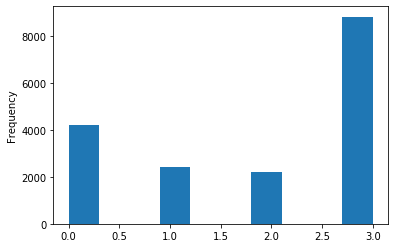

In [35]:
train_labels['accuracy_group'].plot(kind='hist')

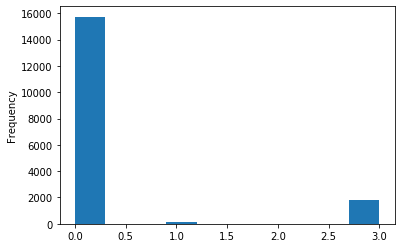

In [36]:
pd.Series(oof).plot(kind='hist')